# RAG 뉴스 비서

** 조건 **



1. 문서로드 (데이터 수집) (RSS)
2. 분할(청크 단위로 분할) (형태소 처리 등  필요)
3. 임베딩 (복수 모델 방식)
4. 벡터 DB화
5. Retrieval (복수의 모델 적용) (RERANK 적용)
6. Prompt
7. LLM(GPT-4)
8. 결과 (Gradio 화면)
 (날짜 검색, 키워드 검색,  요약, 질의 응답 화면)

 *** 세션 아이디. 이력 관리





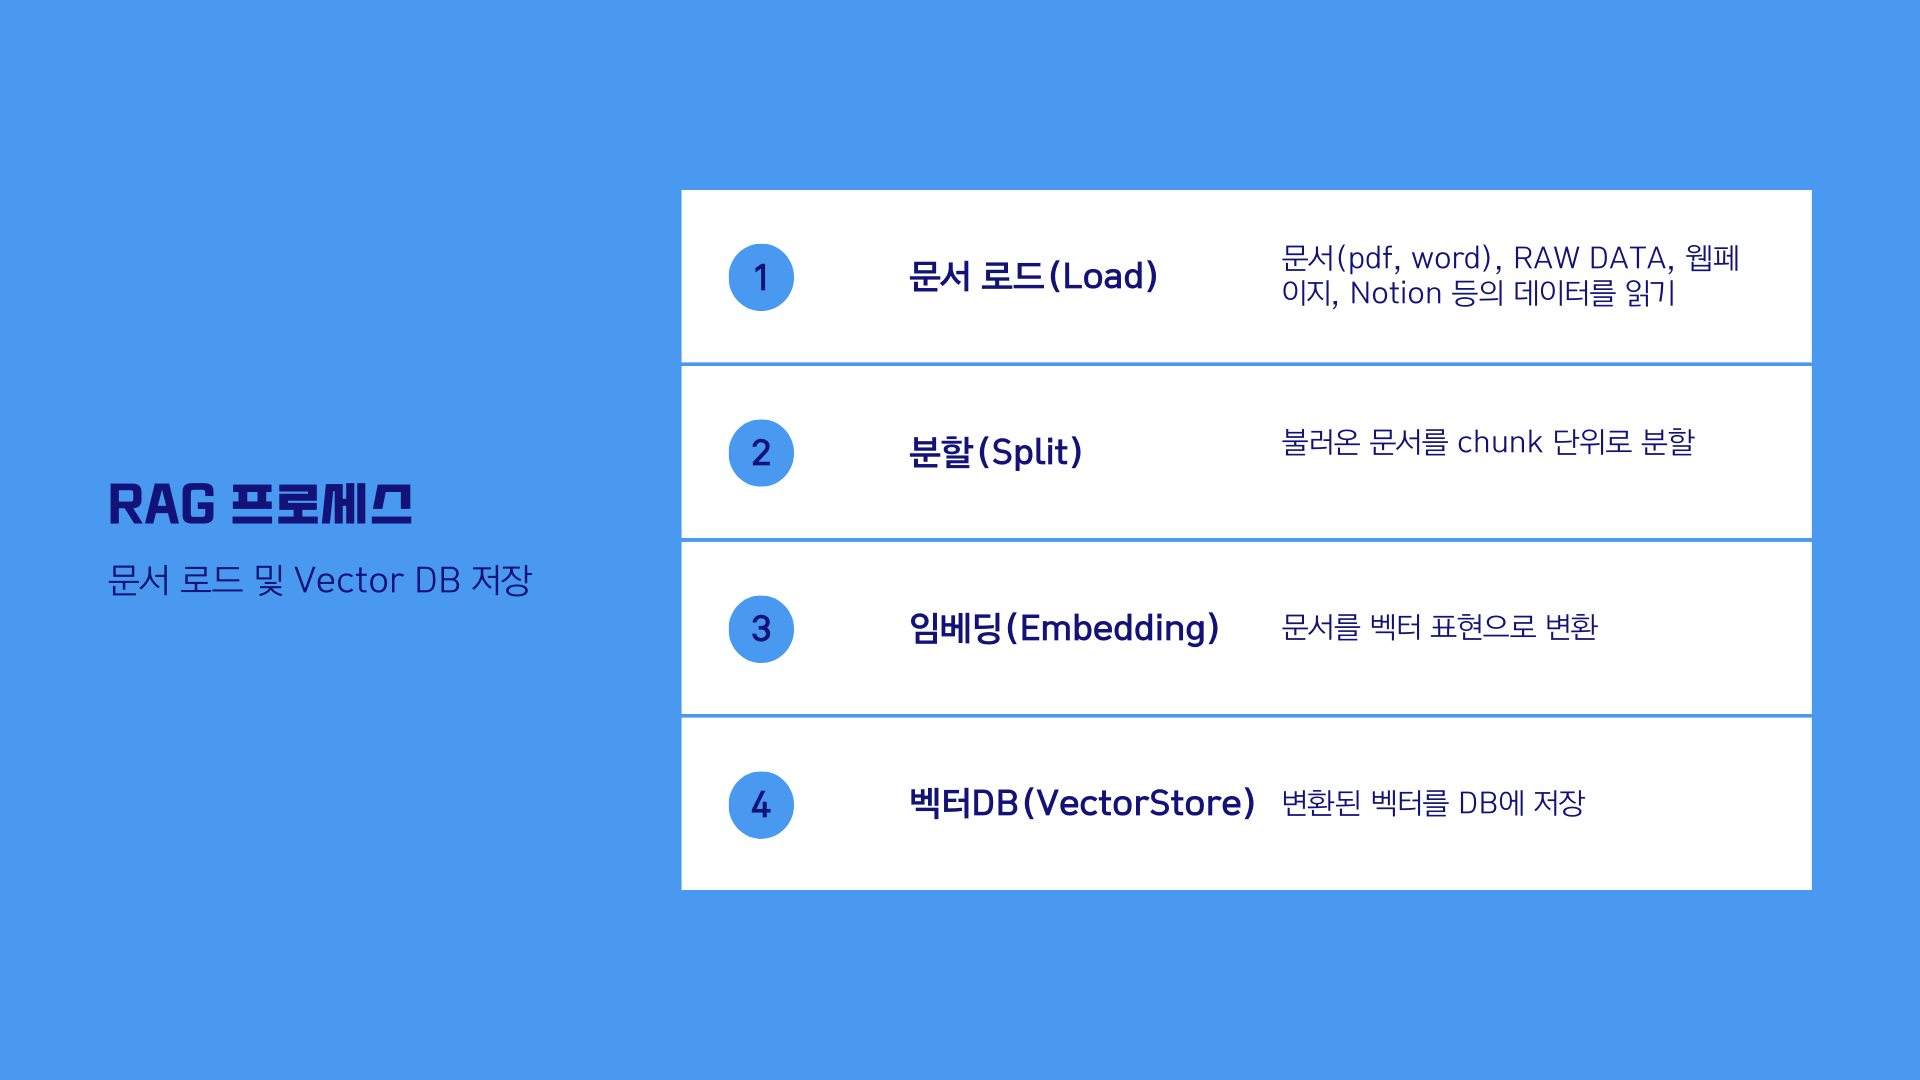

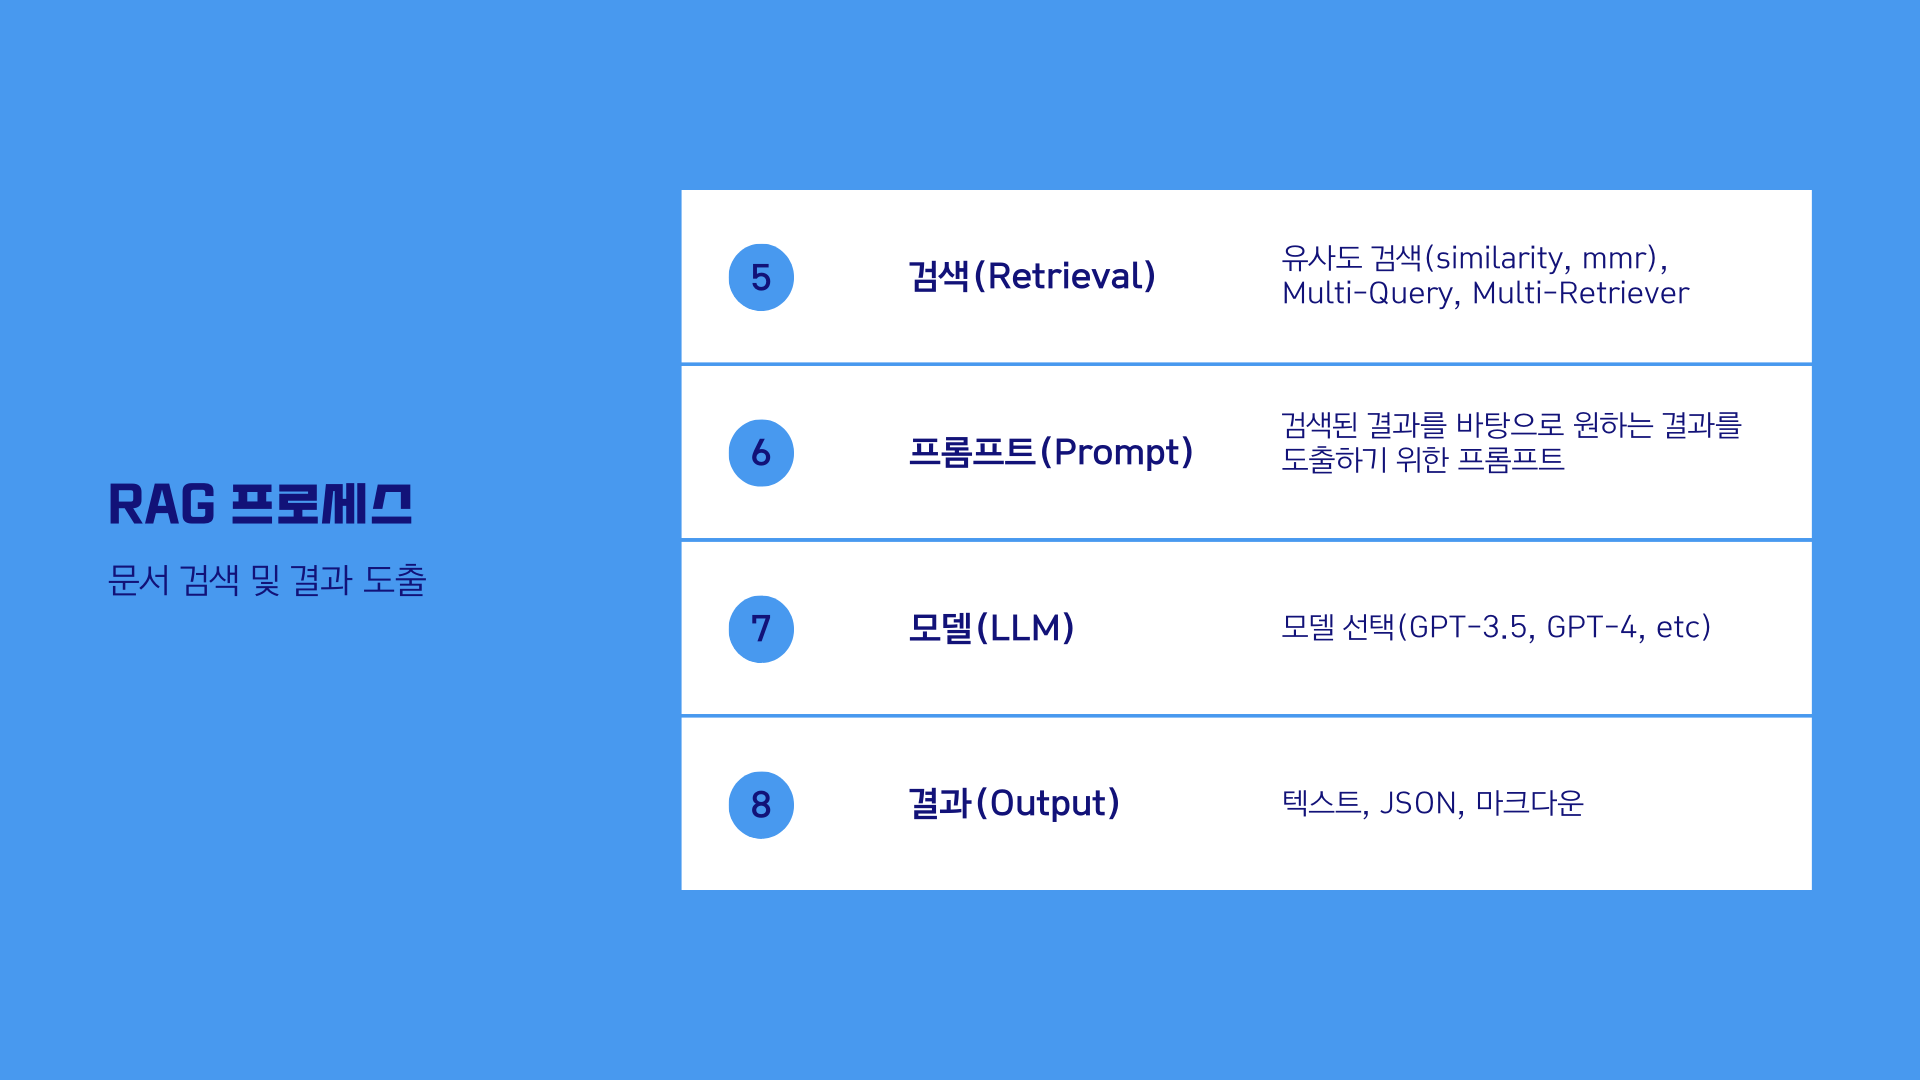

# 구현

In [3]:
# RAG 기반 뉴스 수집 및 요약, 질의응답 뉴스 비서 에이전트
# 코랩 실행용 완전한 구현

# 1. 필요한 라이브러리 설치
!pip install langchain langchain-community langchain-openai langsmith
!pip install faiss-cpu
!pip install gradio
!pip install beautifulsoup4 requests
!pip install sentence-transformers
!pip install konlpy
!pip install newspaper3k
!pip install python-dotenv
!pip install chromadb
!pip install rank_bm25
!pip install langchain-huggingface
!pip install transformers torch
!pip install feedparser
!pip install python-dateutil
!pip install cohere
!pip install torch-audio


ERROR: Could not find a version that satisfies the requirement torch-audio (from versions: none)
ERROR: No matching distribution found for torch-audio


In [ ]:

import os
import datetime
import requests
from bs4 import BeautifulSoup
import pandas as pd
from typing import List, Dict, Any, Optional
import gradio as gr
import warnings
import feedparser
from dateutil import parser as date_parser
import time
import numpy as np
from sentence_transformers import CrossEncoder
warnings.filterwarnings('ignore')

# LangChain imports
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

# 한국어 처리
from konlpy.tag import Okt
import re

# =============================================================================
# 1. 환경 설정 및 API 키 설정
# =============================================================================
from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")


# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "RAG_News_Agent"                 # 수업용 프로젝트명

# =============================================================================
# 2. RSS 기반 뉴스 수집 클래스 (문서로드 - 데이터 수집)
# =============================================================================

class NewsCollector:
    def __init__(self):
        self.okt = Okt()
        # 한국 주요 언론사 RSS 피드 목록
        self.rss_feeds = {
            "연합뉴스": {
                "politics": "https://www.yonhapnews.co.kr/rss/politics.xml",
                "economy": "https://www.yonhapnews.co.kr/rss/economy.xml",
                "society": "https://www.yonhapnews.co.kr/rss/society.xml",
                "culture": "https://www.yonhapnews.co.kr/rss/culture.xml",
                "international": "https://www.yonhapnews.co.kr/rss/international.xml",
                "sports": "https://www.yonhapnews.co.kr/rss/sports.xml"
            },
            "KBS": {
                "politics": "http://world.kbs.co.kr/rss/rss_politics.htm",
                "economy": "http://world.kbs.co.kr/rss/rss_economy.htm",
                "society": "http://world.kbs.co.kr/rss/rss_society.htm",
                "culture": "http://world.kbs.co.kr/rss/rss_culture.htm",
                "international": "http://world.kbs.co.kr/rss/rss_international.htm"
            },
            "SBS": {
                "politics": "https://news.sbs.co.kr/news/SectionRssFeed.do?sectionId=01&plink=RSSREADER",
                "economy": "https://news.sbs.co.kr/news/SectionRssFeed.do?sectionId=02&plink=RSSREADER",
                "society": "https://news.sbs.co.kr/news/SectionRssFeed.do?sectionId=07&plink=RSSREADER"
            },
            "MBC": {
                "politics": "https://imnews.imbc.com/rss/news/politics/rss.xml",
                "economy": "https://imnews.imbc.com/rss/news/economy/rss.xml",
                "society": "https://imnews.imbc.com/rss/news/society/rss.xml"
            }
        }

        # 백업용 샘플 RSS 피드 (테스트용)
        self.sample_feeds = [
            "https://feeds.feedburner.com/TechCrunch/",
            "https://feeds.feedburner.com/venturebeat/SZYF",
            "https://rss.cnn.com/rss/edition.rss"
        ]

    def parse_date(self, date_str: str) -> str:
        """다양한 날짜 형식을 표준 형식으로 변환"""
        try:
            if date_str:
                parsed_date = date_parser.parse(date_str)
                return parsed_date.strftime("%Y-%m-%d")
            else:
                return datetime.datetime.now().strftime("%Y-%m-%d")
        except:
            return datetime.datetime.now().strftime("%Y-%m-%d")

    def clean_text(self, text: str) -> str:
        """텍스트 정제"""
        if not text:
            return ""
        # HTML 태그 제거
        soup = BeautifulSoup(text, 'html.parser')
        text = soup.get_text()
        # 불필요한 공백 제거
        text = ' '.join(text.split())
        return text

    def collect_from_rss_feed(self, feed_url: str, source_name: str = "", category: str = "") -> List[Document]:
        """단일 RSS 피드에서 뉴스 수집"""
        documents = []

        try:
            print(f"RSS 피드 수집 중: {source_name} - {category} ({feed_url})")
            feed = feedparser.parse(feed_url)

            if feed.bozo:
                print(f"RSS 피드 파싱 경고: {feed_url}")

            for entry in feed.entries[:10]:  # 최신 10개 기사만 수집
                try:
                    # 기본 정보 추출
                    title = self.clean_text(entry.get('title', '제목 없음'))

                    # 내용 추출 (summary 또는 description)
                    content = ""
                    if hasattr(entry, 'summary'):
                        content = self.clean_text(entry.summary)
                    elif hasattr(entry, 'description'):
                        content = self.clean_text(entry.description)
                    elif hasattr(entry, 'content') and entry.content:
                        content = self.clean_text(entry.content[0].value)

                    # 내용이 너무 짧으면 스킵
                    if len(content) < 50:
                        continue

                    # 날짜 추출
                    pub_date = ""
                    if hasattr(entry, 'published'):
                        pub_date = self.parse_date(entry.published)
                    elif hasattr(entry, 'updated'):
                        pub_date = self.parse_date(entry.updated)
                    else:
                        pub_date = datetime.datetime.now().strftime("%Y-%m-%d")

                    # 링크 추출
                    link = entry.get('link', '')

                    # 저자/출처 추출
                    author = entry.get('author', source_name)

                    # Document 생성
                    doc = Document(
                        page_content=f"제목: {title}\n내용: {content}",
                        metadata={
                            "source": source_name or "RSS",
                            "category": category,
                            "title": title,
                            "date": pub_date,
                            "link": link,
                            "author": author,
                            "type": "news",
                            "collection_time": datetime.datetime.now().isoformat()
                        }
                    )
                    documents.append(doc)

                except Exception as e:
                    print(f"RSS 항목 처리 오류: {str(e)}")
                    continue

        except Exception as e:
            print(f"RSS 피드 수집 실패: {feed_url}, 에러: {str(e)}")

        return documents

    def collect_korean_news_rss(self, categories: List[str] = None) -> List[Document]:
        """한국 언론사 RSS에서 뉴스 수집"""
        if categories is None:
            categories = ["politics", "economy", "society"]

        all_documents = []

        for source, feed_dict in self.rss_feeds.items():
            for category, feed_url in feed_dict.items():
                if category in categories:
                    docs = self.collect_from_rss_feed(feed_url, source, category)
                    all_documents.extend(docs)
                    time.sleep(1)  # 서버 부하 방지를 위한 지연

        return all_documents

    def collect_international_news_rss(self) -> List[Document]:
        """국제 뉴스 RSS에서 수집 (백업용)"""
        all_documents = []

        for feed_url in self.sample_feeds:
            docs = self.collect_from_rss_feed(feed_url, "International", "tech")
            all_documents.extend(docs)
            time.sleep(1)

        return all_documents

    def collect_news_from_custom_rss(self, rss_urls: List[str]) -> List[Document]:
        """사용자 정의 RSS URL 리스트에서 뉴스 수집"""
        all_documents = []

        for i, url in enumerate(rss_urls):
            docs = self.collect_from_rss_feed(url, f"Custom_Feed_{i+1}", "custom")
            all_documents.extend(docs)
            time.sleep(1)

        return all_documents

    def collect_sample_news(self) -> List[Document]:
        """RSS에서 실제 뉴스 수집 (기본 메서드)"""
        print("RSS 피드에서 뉴스 수집을 시작합니다...")

        all_documents = []

        # 1. 한국 뉴스 수집 시도
        try:
            korean_docs = self.collect_korean_news_rss(["politics", "economy", "society"])
            all_documents.extend(korean_docs)
            print(f"한국 뉴스 {len(korean_docs)}개 수집 완료")
        except Exception as e:
            print(f"한국 뉴스 수집 실패: {str(e)}")

        # 2. 한국 뉴스가 부족하면 국제 뉴스로 보완
        if len(all_documents) < 5:
            try:
                international_docs = self.collect_international_news_rss()
                all_documents.extend(international_docs)
                print(f"국제 뉴스 {len(international_docs)}개 추가 수집")
            except Exception as e:
                print(f"국제 뉴스 수집 실패: {str(e)}")

        # 3. 여전히 부족하면 샘플 데이터 생성
        if len(all_documents) < 3:
            print("RSS 수집이 어려워 샘플 데이터를 생성합니다...")
            sample_docs = self._generate_sample_news()
            all_documents.extend(sample_docs)

        print(f"총 {len(all_documents)}개의 뉴스 문서를 수집했습니다.")
        return all_documents

    def _generate_sample_news(self) -> List[Document]:
        """백업용 샘플 뉴스 데이터 생성"""
        sample_news = [
            {
                "title": "AI 기술 발전으로 인한 일자리 변화 전망",
                "content": "인공지능 기술의 급속한 발전으로 다양한 산업 분야에서 일자리 구조가 변화하고 있다. 전문가들은 AI가 반복적인 업무를 대체하는 동시에 새로운 유형의 직업을 창출할 것으로 전망한다고 밝혔다. 특히 데이터 분석, AI 엔지니어링, 디지털 마케팅 등의 분야에서 인력 수요가 증가할 것으로 예상된다.",
                "date": "2024-01-15",
                "source": "Sample News"
            },
            {
                "title": "글로벌 경제 불확실성 속 한국 경제 전망",
                "content": "국제 정치적 갈등과 인플레이션 압박이 지속되는 가운데 한국 경제의 성장률 전망이 주목받고 있다. 한국은행은 올해 경제성장률을 2.3%로 전망한다고 발표했으며, 수출 회복과 내수 진작을 통한 경제 활성화 방안을 모색하고 있다.",
                "date": "2024-01-14",
                "source": "Sample News"
            },
            {
                "title": "기후변화 대응을 위한 재생에너지 정책 강화",
                "content": "정부는 탄소중립 목표 달성을 위해 재생에너지 비중을 2030년까지 30%로 확대하겠다고 발표했다. 태양광, 풍력 등 청정에너지 인프라 구축에 대규모 투자가 계획되어 있으며, 관련 기업들의 주가 상승이 기대된다.",
                "date": "2024-01-13",
                "source": "Sample News"
            }
        ]

        documents = []
        for news in sample_news:
            doc = Document(
                page_content=f"제목: {news['title']}\n내용: {news['content']}",
                metadata={
                    "source": news['source'],
                    "title": news['title'],
                    "date": news['date'],
                    "type": "news",
                    "category": "sample"
                }
            )
            documents.append(doc)

        return documents

# =============================================================================
# 3. 향상된 한국어 텍스트 전처리 및 분할 클래스 (분할 - 청크 단위 분할)
# =============================================================================

class KoreanTextSplitter:
    def __init__(self, chunk_size: int = 500, chunk_overlap: int = 100):
        self.okt = Okt()
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def preprocess_text(self, text: str) -> str:
        """한국어 텍스트 전처리"""
        # 불필요한 문자 제거하되 검색을 위해 일부 특수문자 보존
        text = re.sub(r'[^\w\s가-힣.,!?()-]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def extract_keywords(self, text: str) -> List[str]:
        """검색용 키워드 추출"""
        try:
            # 형태소 분석
            morphs = self.okt.pos(text, stem=True)

            # 중요한 품사만 추출 (명사, 형용사, 동사, 영어)
            keywords = []
            for word, pos in morphs:
                if pos in ['Noun', 'Adjective', 'Verb'] and len(word) > 1:
                    keywords.append(word)
                elif pos == 'Alpha' and len(word) > 2:  # 영어 단어
                    keywords.append(word.lower())

            # 중복 제거 및 빈도순 정렬
            from collections import Counter
            keyword_counts = Counter(keywords)
            return [word for word, count in keyword_counts.most_common()]

        except Exception as e:
            print(f"키워드 추출 실패: {e}")
            return text.split()

    def morphological_analysis(self, text: str) -> str:
        """형태소 분석 및 정규화"""
        try:
            # 명사와 형용사, 동사 추출
            morphs = self.okt.pos(text, stem=True)
            important_morphs = []

            for word, pos in morphs:
                if pos in ['Noun', 'Adjective', 'Verb'] and len(word) > 1:
                    important_morphs.append(word)
                elif pos == 'Alpha' and len(word) > 2:
                    important_morphs.append(word.lower())

            return ' '.join(important_morphs)
        except:
            return text

    def create_searchable_content(self, text: str) -> str:
        """검색 최적화된 콘텐츠 생성"""
        # 원본 텍스트
        original = self.preprocess_text(text)
        # 형태소 분석 결과
        morphed = self.morphological_analysis(text)
        # 키워드 추출 결과
        keywords = ' '.join(self.extract_keywords(text))

        # 모든 버전을 결합하여 검색 성능 향상
        return f"{original} {morphed} {keywords}"

    def split_documents(self, documents: List[Document]) -> List[Document]:
        """문서를 청크 단위로 분할 (검색 최적화)"""
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            separators=["\n\n", "\n", ". ", ".", " "]
        )

        split_docs = []
        for doc in documents:
            # 텍스트 전처리
            preprocessed_text = self.preprocess_text(doc.page_content)

            # 검색용 콘텐츠 생성
            searchable_content = self.create_searchable_content(doc.page_content)

            # 키워드 추출
            keywords = self.extract_keywords(doc.page_content)

            # 문서 분할
            chunks = splitter.split_text(preprocessed_text)

            for i, chunk in enumerate(chunks):
                # 청크별 키워드도 추출
                chunk_keywords = self.extract_keywords(chunk)
                chunk_searchable = self.create_searchable_content(chunk)

                split_doc = Document(
                    page_content=chunk,
                    metadata={
                        **doc.metadata,
                        'chunk_id': i,
                        'keywords': keywords + chunk_keywords,  # 전체 + 청크 키워드
                        'searchable_content': chunk_searchable,  # 검색 최적화 콘텐츠
                        'morphed_content': self.morphological_analysis(chunk)
                    }
                )
                split_docs.append(split_doc)

        return split_docs

# =============================================================================
# 4. 다중 임베딩 및 벡터 DB 관리 클래스 (임베딩 & 벡터 DB화)
# =============================================================================

class MultiEmbeddingManager:
    def __init__(self):
        # 사용 가능한 임베딩 모델들
        self.embedding_models = {
            "ko-sroberta-multitask": {
                "name": "jhgan/ko-sroberta-multitask",
                "description": "한국어 특화 SentenceTransformer 모델",
                "language": "Korean",
                "size": "~300MB"
            },
            "paraphrase-multilingual": {
                "name": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
                "description": "다국어 지원 경량 모델",
                "language": "Multilingual",
                "size": "~420MB"
            },
            "ko-sentence-transformer": {
                "name": "sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens",
                "description": "100개 언어 지원 BERT 기반 모델",
                "language": "Multilingual",
                "size": "~1.1GB"
            },
            "distiluse-multilingual": {
                "name": "sentence-transformers/distiluse-base-multilingual-cased-v2",
                "description": "다국어 DistilUSE 모델 (빠름)",
                "language": "Multilingual",
                "size": "~540MB"
            },
            "ko-electra": {
                "name": "bongsoo/kpf-sbert-128d",
                "description": "한국어 ELECTRA 기반 경량 모델",
                "language": "Korean",
                "size": "~50MB"
            }
        }

        self.loaded_embeddings = {}
        self.current_model = None

    def load_embedding_model(self, model_key: str) -> HuggingFaceEmbeddings:
        """임베딩 모델 로드"""
        if model_key in self.loaded_embeddings:
            return self.loaded_embeddings[model_key]

        if model_key not in self.embedding_models:
            raise ValueError(f"Unknown embedding model: {model_key}")

        model_info = self.embedding_models[model_key]
        print(f"Loading embedding model: {model_info['name']} ({model_info['size']})")

        try:
            embeddings = HuggingFaceEmbeddings(
                model_name=model_info['name'],
                model_kwargs={'device': 'cpu'}
            )
            self.loaded_embeddings[model_key] = embeddings
            self.current_model = model_key
            return embeddings
        except Exception as e:
            print(f"Failed to load {model_key}: {e}")
            # fallback to default model
            if model_key != "paraphrase-multilingual":
                return self.load_embedding_model("paraphrase-multilingual")
            raise e

    def get_available_models(self) -> Dict[str, str]:
        """사용 가능한 모델 목록 반환"""
        return {key: f"{info['description']} ({info['language']}, {info['size']})"
                for key, info in self.embedding_models.items()}

    def get_current_model_info(self) -> str:
        """현재 사용 중인 모델 정보 반환"""
        if self.current_model:
            info = self.embedding_models[self.current_model]
            return f"🤖 {info['description']} ({info['language']}, {info['size']})"
        return "모델이 로드되지 않음"

class VectorStoreManager:
    def __init__(self, embedding_model_key: str = "ko-sroberta-multitask"):
        self.embedding_manager = MultiEmbeddingManager()
        self.embeddings = self.embedding_manager.load_embedding_model(embedding_model_key)
        self.vector_stores = {}  # 모델별 벡터 스토어 저장
        self.current_vector_store = None
        self.current_model_key = embedding_model_key

    def switch_embedding_model(self, model_key: str) -> str:
        """임베딩 모델 변경"""
        try:
            print(f"Switching to embedding model: {model_key}")
            self.embeddings = self.embedding_manager.load_embedding_model(model_key)
            self.current_model_key = model_key

            # 기존 벡터 스토어가 있다면 사용, 없다면 새로 생성 필요
            if model_key in self.vector_stores:
                self.current_vector_store = self.vector_stores[model_key]
                return f"✅ 모델 변경 완료: {self.embedding_manager.get_current_model_info()}"
            else:
                return f"✅ 모델 변경 완료 (벡터 스토어 재생성 필요): {self.embedding_manager.get_current_model_info()}"
        except Exception as e:
            return f"❌ 모델 변경 실패: {str(e)}"

    def create_vector_store(self, documents: List[Document], model_key: str = None) -> FAISS:
        """벡터 스토어 생성"""
        if model_key and model_key != self.current_model_key:
            self.switch_embedding_model(model_key)

        print(f"임베딩 및 벡터 스토어 생성 중... (모델: {self.current_model_key})")

        try:
            vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_stores[self.current_model_key] = vector_store
            self.current_vector_store = vector_store
            return vector_store
        except Exception as e:
            print(f"벡터 스토어 생성 실패: {e}")
            # fallback model로 재시도
            if self.current_model_key != "paraphrase-multilingual":
                print("기본 모델로 재시도...")
                self.switch_embedding_model("paraphrase-multilingual")
                vector_store = FAISS.from_documents(documents, self.embeddings)
                self.vector_stores[self.current_model_key] = vector_store
                self.current_vector_store = vector_store
                return vector_store
            raise e

    def add_documents(self, documents: List[Document]):
        """기존 벡터 스토어에 문서 추가"""
        if self.current_vector_store:
            self.current_vector_store.add_documents(documents)
            self.vector_stores[self.current_model_key] = self.current_vector_store
        else:
            self.create_vector_store(documents)

    def get_available_models(self) -> Dict[str, str]:
        """사용 가능한 임베딩 모델 목록"""
        return self.embedding_manager.get_available_models()

    def get_current_model_info(self) -> str:
        """현재 모델 정보"""
        return self.embedding_manager.get_current_model_info()

# =============================================================================
# 5. Reranker 클래스 (재순위화)
# =============================================================================

class NewsReranker:
    def __init__(self):
        # 사용 가능한 reranker 모델들
        self.reranker_models = {
            "cross-encoder-ms-marco": {
                "name": "cross-encoder/ms-marco-MiniLM-L-6-v2",
                "description": "MS MARCO 데이터셋으로 학습된 경량 CrossEncoder",
                "language": "English (Multilingual capable)",
                "size": "~80MB"
            },
            "cross-encoder-multilingual": {
                "name": "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1",
                "description": "다국어 mMARCO CrossEncoder",
                "language": "Multilingual",
                "size": "~400MB"
            },
            "bge-reranker": {
                "name": "BAAI/bge-reranker-base",
                "description": "BGE Reranker (중국어/영어 특화)",
                "language": "Chinese/English",
                "size": "~400MB"
            }
        }

        self.loaded_rerankers = {}
        self.current_reranker = None
        self.current_model_key = None

    def load_reranker(self, model_key: str = "cross-encoder-ms-marco") -> CrossEncoder:
        """Reranker 모델 로드"""
        if model_key in self.loaded_rerankers:
            self.current_reranker = self.loaded_rerankers[model_key]
            self.current_model_key = model_key
            return self.current_reranker

        if model_key not in self.reranker_models:
            model_key = "cross-encoder-ms-marco"  # fallback

        model_info = self.reranker_models[model_key]
        print(f"Loading reranker: {model_info['name']} ({model_info['size']})")

        try:
            reranker = CrossEncoder(model_info['name'])
            self.loaded_rerankers[model_key] = reranker
            self.current_reranker = reranker
            self.current_model_key = model_key
            return reranker
        except Exception as e:
            print(f"Failed to load reranker {model_key}: {e}")
            # fallback to None (no reranking)
            self.current_reranker = None
            return None

    def rerank_documents(self, query: str, documents: List[Document], top_k: int = 10) -> List[Document]:
        """문서 재순위화"""
        if not self.current_reranker or len(documents) <= 1:
            return documents[:top_k]

        try:
            # 쿼리-문서 쌍 생성
            query_doc_pairs = [(query, doc.page_content[:512]) for doc in documents]

            # 점수 계산
            scores = self.current_reranker.predict(query_doc_pairs)

            # 점수와 문서를 결합하여 정렬
            scored_docs = list(zip(scores, documents))
            scored_docs.sort(key=lambda x: x[0], reverse=True)

            # 상위 top_k 개 문서 반환
            reranked_docs = [doc for score, doc in scored_docs[:top_k]]

            print(f"Reranked {len(documents)} documents to top {len(reranked_docs)} with model: {self.current_model_key}")
            return reranked_docs

        except Exception as e:
            print(f"Reranking failed: {e}, returning original order")
            return documents[:top_k]

    def get_available_rerankers(self) -> Dict[str, str]:
        """사용 가능한 reranker 모델 목록"""
        models = {key: f"{info['description']} ({info['language']}, {info['size']})"
                 for key, info in self.reranker_models.items()}
        models["none"] = "Reranking 사용하지 않음"
        return models

    def get_current_reranker_info(self) -> str:
        """현재 reranker 정보"""
        if self.current_reranker and self.current_model_key:
            info = self.reranker_models[self.current_model_key]
            return f"🔄 {info['description']} ({info['language']}, {info['size']})"
        return "🔄 Reranking 사용하지 않음"

# =============================================================================
# 6. 향상된 복합 검색 시스템 클래스 (Retrieval - 복수의 모델 적용 + Rerank)
# =============================================================================

class AdvancedHybridRetriever:
    def __init__(self, documents: List[Document], vector_store: FAISS,
                 reranker: NewsReranker = None, reranker_model: str = "cross-encoder-ms-marco"):
        self.documents = documents
        self.vector_store = vector_store
        self.reranker = reranker or NewsReranker()

        # Reranker 로드
        if reranker_model != "none":
            self.reranker.load_reranker(reranker_model)

        # BM25 검색기 생성
        try:
            texts = [doc.page_content for doc in documents]
            self.bm25_retriever = BM25Retriever.from_texts(
                texts,
                metadatas=[doc.metadata for doc in documents]
            )
            self.bm25_retriever.k = 15  # rerank를 위해 더 많이 가져옴
        except Exception as e:
            print(f"BM25 검색기 생성 오류: {e}")
            self.bm25_retriever = None

        # 벡터 검색기
        self.vector_retriever = vector_store.as_retriever(
            search_kwargs={"k": 15}  # rerank를 위해 더 많이 가져옴
        )

        # 앙상블 검색기 (하이브리드)
        if self.bm25_retriever:
            self.ensemble_retriever = EnsembleRetriever(
                retrievers=[self.bm25_retriever, self.vector_retriever],
                weights=[0.4, 0.6]
            )
        else:
            self.ensemble_retriever = self.vector_retriever

    def search_by_similarity(self, query: str, k: int = 5, use_rerank: bool = True) -> List[Document]:
        """유사도 기반 검색 + Rerank"""
        docs = self.vector_retriever.invoke(query)
        if use_rerank and self.reranker.current_reranker:
            docs = self.reranker.rerank_documents(query, docs, k)
        return docs[:k]

    def search_by_keyword(self, query: str, k: int = 5, use_rerank: bool = True) -> List[Document]:
        """키워드 기반 검색 + Rerank"""
        if self.bm25_retriever:
            docs = self.bm25_retriever.invoke(query)
        else:
            docs = self.vector_retriever.invoke(query)

        if use_rerank and self.reranker.current_reranker:
            docs = self.reranker.rerank_documents(query, docs, k)
        return docs[:k]

    def hybrid_search(self, query: str, k: int = 5, use_rerank: bool = True) -> List[Document]:
        """하이브리드 검색 + Rerank"""
        docs = self.ensemble_retriever.invoke(query)
        if use_rerank and self.reranker.current_reranker:
            docs = self.reranker.rerank_documents(query, docs, k)
        return docs[:k]

    def advanced_search(self, query: str, method: str = "hybrid", k: int = 5,
                       use_rerank: bool = True, rerank_top_k: int = 15) -> List[Document]:
        """고급 검색 (모든 방법 + Rerank)"""
        if method == "similarity":
            # 벡터 검색
            docs = self.vector_retriever.invoke(query)[:rerank_top_k]
        elif method == "keyword":
            # BM25 검색
            if self.bm25_retriever:
                docs = self.bm25_retriever.invoke(query)[:rerank_top_k]
            else:
                docs = self.vector_retriever.invoke(query)[:rerank_top_k]
        elif method == "ensemble":
            # 앙상블 검색 (BM25 + Vector)
            docs = self.ensemble_retriever.invoke(query)[:rerank_top_k]
        else:  # method == "fusion"
            # 다중 방법 융합
            vector_docs = self.vector_retriever.invoke(query)[:10]
            if self.bm25_retriever:
                keyword_docs = self.bm25_retriever.invoke(query)[:10]
                # 문서 융합 (중복 제거)
                seen_docs = set()
                fused_docs = []
                for doc in vector_docs + keyword_docs:
                    doc_id = doc.page_content[:100]  # 간단한 중복 체크
                    if doc_id not in seen_docs:
                        seen_docs.add(doc_id)
                        fused_docs.append(doc)
                docs = fused_docs[:rerank_top_k]
            else:
                docs = vector_docs

        # Rerank 적용
        if use_rerank and self.reranker.current_reranker:
            docs = self.reranker.rerank_documents(query, docs, k)

        return docs[:k]

    def search_by_date(self, date: str) -> List[Document]:
        """날짜 기반 검색"""
        filtered_docs = [doc for doc in self.documents
                        if doc.metadata.get('date') == date]
        return filtered_docs

    def switch_reranker(self, reranker_model: str) -> str:
        """Reranker 모델 변경"""
        if reranker_model == "none":
            self.reranker.current_reranker = None
            return "🔄 Reranking이 비활성화되었습니다."
        else:
            self.reranker.load_reranker(reranker_model)
            return f"🔄 Reranker 변경 완료: {self.reranker.get_current_reranker_info()}"

# =============================================================================
# 6. 프롬프트 템플릿 (Prompt)
# =============================================================================

class PromptManager:
    def __init__(self):
        self.qa_template = PromptTemplate(
            template="""
            당신은 한국어 뉴스 전문 AI 어시스턴트입니다.
            주어진 뉴스 문서들을 바탕으로 사용자의 질문에 정확하고 유용한 답변을 제공하세요.

            관련 뉴스 문서들:
            {context}

            사용자 질문: {question}

            답변 가이드라인:
            1. 제공된 뉴스 문서의 정보만을 사용하여 답변하세요
            2. 답변은 명확하고 구체적이어야 합니다
            3. 출처 뉴스의 제목을 함께 언급하세요
            4. 확실하지 않은 정보는 "제공된 문서에서는 명확하지 않습니다"라고 답하세요

            답변:
            """,
            input_variables=["context", "question"]
        )

        self.summary_template = PromptTemplate(
            template="""
            다음 뉴스 문서들을 요약해주세요:

            {context}

            요약 요구사항:
            1. 주요 내용을 3-5개 요점으로 정리하세요
            2. 각 요점은 한 문장으로 간결하게 작성하세요
            3. 중요한 키워드는 볼드체로 표시하세요
            4. 날짜와 출처 정보를 포함하세요

            요약:
            """,
            input_variables=["context"]
        )

# =============================================================================
# 7. LLM 및 체인 관리 클래스 (LLM - GPT-4)
# =============================================================================

class LLMManager:
    def __init__(self, api_key: str):
        self.llm = ChatOpenAI(
            model="gpt-4",
            temperature=0.3,
            api_key=api_key
        )
        self.prompt_manager = PromptManager()

    def create_qa_chain(self, retriever):
        """질의응답 체인 생성"""
        return RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=retriever,
            chain_type_kwargs={
                "prompt": self.prompt_manager.qa_template
            },
            return_source_documents=True
        )

    def create_summary_chain(self, retriever):
        """요약 체인 생성"""
        return RetrievalQA.from_chain_type(
            llm=self.llm,
            chain_type="stuff",
            retriever=retriever,
            chain_type_kwargs={
                "prompt": self.prompt_manager.summary_template
            },
            return_source_documents=True
        )

# =============================================================================
# 8. 고급 RAG 시스템 클래스
# =============================================================================

class NewsRAGSystem:
    def __init__(self, openai_api_key: str, embedding_model: str = "ko-sroberta-multitask",
                 reranker_model: str = "cross-encoder-ms-marco"):
        self.news_collector = NewsCollector()
        self.text_splitter = KoreanTextSplitter()
        self.vector_manager = VectorStoreManager(embedding_model)
        self.llm_manager = LLMManager(openai_api_key)
        self.reranker = NewsReranker()
        self.retriever = None
        self.documents = []
        self.qa_chain = None
        self.summary_chain = None
        self.current_embedding_model = embedding_model
        self.current_reranker_model = reranker_model

    def initialize_system(self, news_categories: List[str] = None,
                         embedding_model: str = None, reranker_model: str = None):
        """시스템 초기화 및 RSS 데이터 로드"""
        print("🚀 고급 뉴스 RAG 시스템 초기화 중...")

        # 모델 설정
        if embedding_model:
            self.current_embedding_model = embedding_model
        if reranker_model:
            self.current_reranker_model = reranker_model

        # 1. RSS에서 뉴스 수집
        print("1. RSS 피드에서 뉴스 데이터 수집 중...")
        if news_categories:
            self.documents = self.news_collector.collect_korean_news_rss(news_categories)
        else:
            self.documents = self.news_collector.collect_sample_news()

        if not self.documents:
            print("뉴스 수집에 실패했습니다. 시스템을 다시 시도해주세요.")
            return False

        # 2. 텍스트 분할
        print("2. 텍스트 분할 및 전처리 중...")
        split_documents = self.text_splitter.split_documents(self.documents)

        # 3. 임베딩 모델 로드 및 벡터 스토어 생성
        print("3. 임베딩 모델 로드 및 벡터 스토어 생성 중...")
        vector_store = self.vector_manager.create_vector_store(split_documents, self.current_embedding_model)

        # 4. Reranker 로드
        print("4. Reranker 모델 로드 중...")
        if self.current_reranker_model != "none":
            self.reranker.load_reranker(self.current_reranker_model)

        # 5. 고급 검색기 생성
        print("5. 고급 하이브리드 검색기 생성 중...")
        self.retriever = AdvancedHybridRetriever(
            split_documents, vector_store, self.reranker, self.current_reranker_model
        )

        # 6. LLM 체인 생성
        print("6. LLM 체인 생성 중...")
        self.qa_chain = self.llm_manager.create_qa_chain(
            self.retriever.ensemble_retriever
        )
        self.summary_chain = self.llm_manager.create_summary_chain(
            self.retriever.ensemble_retriever
        )

        print("✅ 고급 시스템 초기화 완료!")
        print(f"📊 임베딩: {self.vector_manager.get_current_model_info()}")
        print(f"🔄 Reranker: {self.reranker.get_current_reranker_info()}")
        return True

    def switch_embedding_model(self, model_key: str) -> str:
        """임베딩 모델 변경"""
        result = self.vector_manager.switch_embedding_model(model_key)
        self.current_embedding_model = model_key

        # 벡터 스토어 재생성이 필요한 경우
        if "재생성 필요" in result:
            try:
                split_documents = self.text_splitter.split_documents(self.documents)
                vector_store = self.vector_manager.create_vector_store(split_documents, model_key)
                self.retriever.vector_store = vector_store
                self.retriever.vector_retriever = vector_store.as_retriever(search_kwargs={"k": 15})
                return f"✅ 임베딩 모델 변경 및 벡터 스토어 재생성 완료: {self.vector_manager.get_current_model_info()}"
            except Exception as e:
                return f"❌ 벡터 스토어 재생성 실패: {str(e)}"

        return result

    def switch_reranker_model(self, model_key: str) -> str:
        """Reranker 모델 변경"""
        if self.retriever:
            return self.retriever.switch_reranker(model_key)
        else:
            self.current_reranker_model = model_key
            return f"Reranker 설정 저장됨: {model_key}"

    def refresh_news(self, categories: List[str] = None):
        """뉴스 데이터 새로고침"""
        print("뉴스 데이터를 새로고침합니다...")
        try:
            if categories:
                new_documents = self.news_collector.collect_korean_news_rss(categories)
            else:
                new_documents = self.news_collector.collect_sample_news()

            if new_documents:
                self.documents.extend(new_documents)
                # 중복 제거 (제목 기준)
                seen_titles = set()
                unique_docs = []
                for doc in self.documents:
                    title = doc.metadata.get('title', '')
                    if title not in seen_titles:
                        seen_titles.add(title)
                        unique_docs.append(doc)
                self.documents = unique_docs

                # 벡터 스토어 업데이트
                split_documents = self.text_splitter.split_documents(new_documents)
                self.vector_manager.add_documents(split_documents)

                # 검색기 업데이트
                if self.retriever:
                    self.retriever.documents.extend(split_documents)

                print(f"{len(new_documents)}개의 새로운 뉴스를 추가했습니다.")
                return f"✅ 성공: {len(new_documents)}개 뉴스 추가됨"
            else:
                return "❌ 새로운 뉴스를 찾지 못했습니다."
        except Exception as e:
            return f"❌ 뉴스 새로고침 실패: {str(e)}"

    def search_news(self, query: str, search_method: str = "hybrid", use_rerank: bool = True, k: int = 5):
        """고급 뉴스 검색"""
        if not self.retriever:
            return []

        # 검색 방법별 분기
        if search_method == "similarity":
            return self.retriever.search_by_similarity(query, k, use_rerank)
        elif search_method == "keyword":
            return self.retriever.search_by_keyword(query, k, use_rerank)
        elif search_method == "hybrid":
            return self.retriever.hybrid_search(query, k, use_rerank)
        else:  # advanced methods
            return self.retriever.advanced_search(query, search_method, k, use_rerank)

    def search_by_date(self, date: str):
        """날짜별 뉴스 검색"""
        return self.retriever.search_by_date(date) if self.retriever else []

    def answer_question(self, question: str):
        """질의응답"""
        if not self.qa_chain:
            return "시스템이 초기화되지 않았습니다."

        try:
            result = self.qa_chain.invoke({"query": question})
            return result["result"]
        except Exception as e:
            return f"답변 생성 중 오류 발생: {str(e)}"

    def summarize_news(self, query: str = ""):
        """뉴스 요약"""
        if not self.summary_chain:
            return "시스템이 초기화되지 않았습니다."

        try:
            if query:
                # 특정 키워드 관련 뉴스 요약
                result = self.summary_chain.invoke({"query": query})
                return result["result"]
            else:
                # 전체 뉴스 요약
                context = "\n".join([doc.page_content for doc in self.documents[:3]])
                result = self.llm_manager.llm.invoke(
                    self.llm_manager.prompt_manager.summary_template.format(
                        context=context
                    )
                )
                return result.content
        except Exception as e:
            return f"요약 생성 중 오류 발생: {str(e)}"

    def get_system_status(self) -> Dict[str, Any]:
        """시스템 상태 정보 반환"""
        return {
            "total_documents": len(self.documents),
            "latest_date": max([doc.metadata.get('date', '0000-00-00')
                              for doc in self.documents]) if self.documents else "없음",
            "sources": list(set([doc.metadata.get('source', 'Unknown')
                               for doc in self.documents])),
            "embedding_model": self.vector_manager.get_current_model_info(),
            "reranker_model": self.reranker.get_current_reranker_info(),
            "available_embedding_models": list(self.vector_manager.get_available_models().keys()),
            "available_reranker_models": list(self.reranker.get_available_rerankers().keys())
        }

# =============================================================================
# 9. Gradio 인터페이스 (결과 - Gradio 화면)
# =============================================================================

class NewsAssistantUI:
    def __init__(self, rag_system: NewsRAGSystem):
        self.rag_system = rag_system

    def create_interface(self):
        """고급 Gradio 인터페이스 생성"""

        def get_system_status():
            """시스템 상태 정보 업데이트"""
            try:
                status = self.rag_system.get_system_status()
                return (
                    f"📊 총 {status['total_documents']}개 뉴스 | 최신: {status['latest_date']} | 출처: {', '.join(status['sources'][:3])}",
                    status['embedding_model'],
                    status['reranker_model']
                )
            except:
                return "📊 시스템 상태 확인 불가", "모델 정보 없음", "Reranker 정보 없음"

        def refresh_news_ui(categories):
            """뉴스 새로고침 UI 함수"""
            if not categories:
                categories = ["politics", "economy", "society"]
            result = self.rag_system.refresh_news(categories)
            return result, *get_system_status()

        def switch_embedding_model_ui(model_key):
            """임베딩 모델 변경 UI"""
            if not model_key:
                return "모델을 선택해주세요."
            result = self.rag_system.switch_embedding_model(model_key)
            return result

        def switch_reranker_ui(reranker_key):
            """Reranker 모델 변경 UI"""
            result = self.rag_system.switch_reranker_model(reranker_key)
            return result

        def advanced_search_ui(keyword, search_method, use_rerank, result_count):
            """향상된 고급 검색 UI 함수"""
            if not keyword.strip():
                return "키워드를 입력해주세요."

            try:
                # 검색 실행
                docs = self.rag_system.search_news(
                    keyword, search_method.lower().replace(" ", "_"),
                    use_rerank, result_count
                )

                # 검색 결과가 없을 때 대안 제시
                if not docs:
                    # 형태소 분석을 통한 키워드 분석
                    okt = Okt()
                    try:
                        morphs = okt.pos(keyword, stem=True)
                        keywords = [word for word, pos in morphs if pos in ['Noun', 'Adjective', 'Verb']]

                        suggestions = []
                        if keywords:
                            suggestions.append(f"📝 추출된 키워드: {', '.join(keywords[:5])}")

                            # 개별 키워드로 재검색 시도
                            for kw in keywords[:3]:
                                if len(kw) > 1:
                                    kw_docs = self.rag_system.search_news(kw, "keyword", use_rerank, 3)
                                    if kw_docs:
                                        suggestions.append(f"🔍 '{kw}' 검색 결과: {len(kw_docs)}개")

                        suggestion_text = "\n".join(suggestions) if suggestions else ""

                        return f"""❌ '{keyword}' 검색 결과가 없습니다.

💡 검색 개선 제안:
{suggestion_text}

🔧 검색 팁:
• 더 일반적인 키워드 사용해보세요 (예: 'AI' 대신 '인공지능')
• 여러 키워드를 조합해보세요 (예: '경제 성장', 'IT 기업')
• 다른 검색 방법을 시도해보세요 (Fusion 또는 Similarity)
• Reranking을 비활성화해보세요

📰 사용 가능한 주요 주제: 정치, 경제, 사회, 기술, AI, 문화"""

                    except Exception as e:
                        return f"""❌ '{keyword}' 검색 결과가 없습니다.

🔧 다음을 시도해보세요:
• 키워드를 더 간단하게 입력 (예: '경제', '정치', 'AI')
• 다른 검색 방법 선택 (Fusion 권장)
• 결과 개수를 늘려보세요
• Reranking을 끄고 다시 시도

📊 현재 뉴스 개수: {len(self.rag_system.documents)}개"""

                # 검색 결과 포맷팅
                result = f"🎯 {search_method} 검색 결과 (Rerank: {'ON' if use_rerank else 'OFF'}):\n"
                result += f"📊 총 {len(docs)}개 결과 (요청: {result_count}개)\n\n"

                for i, doc in enumerate(docs, 1):
                    title = doc.metadata.get('title', '제목 없음')
                    date = doc.metadata.get('date', '날짜 없음')
                    source = doc.metadata.get('source', '출처 없음')
                    category = doc.metadata.get('category', '')

                    # 키워드 하이라이트를 위한 콘텐츠 처리
                    content = doc.page_content[:300]

                    # 검색 키워드 하이라이트 (간단한 버전)
                    try:
                        okt = Okt()
                        search_keywords = [word for word, pos in okt.pos(keyword, stem=True)
                                         if pos in ['Noun', 'Adjective', 'Verb']]
                        for kw in search_keywords:
                            if len(kw) > 1 and kw in content:
                                content = content.replace(kw, f"**{kw}**")
                    except:
                        pass

                    content += "..."

                    result += f"**{i}. {title}**\n"
                    result += f"📅 {date} | 📰 {source}"
                    if category:
                        result += f" | 🏷️ {category}"

                    # 키워드 매칭 정보 추가
                    doc_keywords = doc.metadata.get('keywords', [])
                    if doc_keywords:
                        matched_keywords = [kw for kw in doc_keywords[:5]
                                          if any(sk in kw.lower() for sk in keyword.lower().split())]
                        if matched_keywords:
                            result += f" | 🔑 {', '.join(matched_keywords[:3])}"

                    result += f"\n💬 {content}\n"

                    # 검색 방법별 추가 정보
                    if search_method == "Keyword" and doc.metadata.get('morphed_content'):
                        morph_preview = doc.metadata['morphed_content'][:50]
                        result += f"🔍 키워드: {morph_preview}...\n"

                    result += "\n"

                # 검색 성능 정보 추가
                result += f"\n📈 검색 성능 정보:\n"
                result += f"• 검색 방법: {search_method}\n"
                result += f"• Reranking: {'적용됨' if use_rerank else '미적용'}\n"
                result += f"• 전체 문서 수: {len(self.rag_system.documents)}개\n"

                return result

            except Exception as e:
                error_msg = f"❌ 검색 중 오류 발생: {str(e)}"

                # 구체적인 오류 대응 제안
                if "BM25" in str(e):
                    error_msg += "\n\n💡 해결 방법: Similarity 검색 방법을 사용해보세요."
                elif "rerank" in str(e).lower():
                    error_msg += "\n\n💡 해결 방법: Reranking을 비활성화하고 다시 시도하세요."
                elif "embedding" in str(e).lower():
                    error_msg += "\n\n💡 해결 방법: 임베딩 모델을 변경해보세요."
                else:
                    error_msg += "\n\n💡 해결 방법:\n• 키워드를 더 간단하게 입력\n• 다른 검색 방법 시도\n• 시스템 새로고침"

                return error_msg

        def search_by_date_ui(date):
            """날짜 검색 UI 함수"""
            if not date:
                return "날짜를 입력해주세요."

            docs = self.rag_system.search_by_date(date)
            result = f"📅 {date} 뉴스 검색 결과:\n\n"

            for i, doc in enumerate(docs, 1):
                title = doc.metadata.get('title', '제목 없음')
                source = doc.metadata.get('source', '출처 없음')
                content = doc.page_content[:200] + "..."
                result += f"**{i}. {title}**\n📰 {source}\n💬 {content}\n\n"

            return result if docs else f"❌ {date}에 해당하는 뉴스가 없습니다."

        def qa_ui(question):
            """질의응답 UI 함수"""
            if not question.strip():
                return "질문을 입력해주세요."
            return self.rag_system.answer_question(question)

        def summary_ui(keyword):
            """요약 UI 함수"""
            if keyword.strip():
                return self.rag_system.summarize_news(keyword)
            else:
                return self.rag_system.summarize_news()

        def add_custom_rss(rss_url):
            """사용자 정의 RSS 추가"""
            if not rss_url.strip():
                return "RSS URL을 입력해주세요."
            try:
                urls = [url.strip() for url in rss_url.split('\n') if url.strip()]
                docs = self.rag_system.news_collector.collect_news_from_custom_rss(urls)
                if docs:
                    self.rag_system.documents.extend(docs)
                    return f"✅ {len(docs)}개의 뉴스를 성공적으로 추가했습니다."
                else:
                    return "❌ RSS 피드에서 뉴스를 수집하지 못했습니다."
            except Exception as e:
                return f"❌ RSS 추가 실패: {str(e)}"

        # 초기 상태 정보
        news_status, embedding_info, reranker_info = get_system_status()

        # Gradio 인터페이스 구성
        with gr.Blocks(title="고급 RSS 뉴스 비서 AI", theme=gr.themes.Soft()) as interface:
            gr.Markdown("# 🚀 고급 RSS 뉴스 비서 AI")
            gr.Markdown("**다중 임베딩 모델 + Reranking + 하이브리드 검색** 기반 차세대 뉴스 분석 시스템")

            # 시스템 상태 및 모델 관리 섹션
            with gr.Row():
                with gr.Column(scale=2):
                    system_status = gr.Textbox(
                        label="📊 시스템 상태",
                        value=news_status,
                        interactive=False
                    )
                with gr.Column(scale=1):
                    refresh_btn = gr.Button("🔄 뉴스 새로고침", variant="primary")

            # 모델 설정 섹션
            with gr.Row():
                with gr.Column():
                    embedding_status = gr.Textbox(
                        label="🤖 현재 임베딩 모델",
                        value=embedding_info,
                        interactive=False
                    )
                    embedding_choice = gr.Dropdown(
                        choices=list(self.rag_system.vector_manager.get_available_models().keys()),
                        label="🔧 임베딩 모델 변경",
                        value=self.rag_system.current_embedding_model
                    )
                    change_embedding_btn = gr.Button("임베딩 모델 변경", variant="secondary")

                with gr.Column():
                    reranker_status = gr.Textbox(
                        label="🔄 현재 Reranker",
                        value=reranker_info,
                        interactive=False
                    )
                    reranker_choice = gr.Dropdown(
                        choices=list(self.rag_system.reranker.get_available_rerankers().keys()),
                        label="🔧 Reranker 변경",
                        value=self.rag_system.current_reranker_model
                    )
                    change_reranker_btn = gr.Button("Reranker 변경", variant="secondary")

            # 뉴스 카테고리 선택
            with gr.Row():
                news_categories = gr.CheckboxGroup(
                    choices=["politics", "economy", "society", "culture", "international", "sports"],
                    value=["politics", "economy", "society"],
                    label="📋 수집할 뉴스 카테고리"
                )

            # 결과 표시용 텍스트박스들
            refresh_result = gr.Textbox(label="새로고침 결과", visible=False)
            embedding_result = gr.Textbox(label="임베딩 모델 변경 결과", visible=False)
            reranker_result = gr.Textbox(label="Reranker 변경 결과", visible=False)

            # 이벤트 핸들러 설정
            refresh_btn.click(
                refresh_news_ui,
                inputs=news_categories,
                outputs=[refresh_result, system_status, embedding_status, reranker_status]
            ).then(
                lambda x: gr.update(visible=True, value=x),
                inputs=refresh_result,
                outputs=refresh_result
            )

            change_embedding_btn.click(
                switch_embedding_model_ui,
                inputs=embedding_choice,
                outputs=embedding_result
            ).then(
                get_system_status,
                outputs=[system_status, embedding_status, reranker_status]
            ).then(
                lambda x: gr.update(visible=True, value=x),
                inputs=embedding_result,
                outputs=embedding_result
            )

            change_reranker_btn.click(
                switch_reranker_ui,
                inputs=reranker_choice,
                outputs=reranker_result
            ).then(
                get_system_status,
                outputs=[system_status, embedding_status, reranker_status]
            ).then(
                lambda x: gr.update(visible=True, value=x),
                inputs=reranker_result,
                outputs=reranker_result
            )

            with gr.Tabs():
                # 고급 검색 탭
                with gr.TabItem("🎯 고급 검색"):
                    gr.Markdown("### 🔍 다중 모델 기반 고급 검색 시스템")
                    with gr.Row():
                        with gr.Column():
                            keyword_input = gr.Textbox(
                                label="검색 키워드",
                                placeholder="예: AI, 경제, 기술, 정치"
                            )
                            search_method = gr.Dropdown(
                                choices=["Hybrid", "Similarity", "Keyword", "Fusion"],
                                label="🔧 검색 방법",
                                value="Hybrid",
                                info="Hybrid: BM25+벡터, Similarity: 의미검색, Keyword: 키워드검색, Fusion: 다중방법융합"
                            )
                            with gr.Row():
                                use_rerank = gr.Checkbox(
                                    label="🔄 Reranking 사용",
                                    value=True,
                                    info="검색 결과를 CrossEncoder로 재순위화"
                                )
                                result_count = gr.Slider(
                                    minimum=3, maximum=20, step=1, value=5,
                                    label="📊 결과 개수"
                                )
                            search_btn = gr.Button("🎯 고급 검색", variant="primary")

                        with gr.Column():
                            search_output = gr.Textbox(
                                label="🔍 검색 결과",
                                lines=15,
                                max_lines=25
                            )

                    search_btn.click(
                        advanced_search_ui,
                        inputs=[keyword_input, search_method, use_rerank, result_count],
                        outputs=search_output
                    )

                # 날짜 검색 탭
                with gr.TabItem("📅 날짜별 검색"):
                    with gr.Row():
                        with gr.Column():
                            date_input = gr.Textbox(
                                label="날짜",
                                placeholder="YYYY-MM-DD (예: 2024-01-15)"
                            )
                            date_search_btn = gr.Button("📅 검색", variant="primary")

                        with gr.Column():
                            date_output = gr.Textbox(
                                label="검색 결과",
                                lines=12,
                                max_lines=20
                            )

                    date_search_btn.click(
                        search_by_date_ui,
                        inputs=date_input,
                        outputs=date_output
                    )

                # 질의응답 탭
                with gr.TabItem("❓ 질의응답"):
                    gr.Markdown("### 🤖 GPT-4 기반 뉴스 분석 및 질의응답")
                    with gr.Row():
                        with gr.Column():
                            question_input = gr.Textbox(
                                label="질문",
                                placeholder="예: 최근 경제 상황은? AI 관련 뉴스의 주요 내용은?",
                                lines=3
                            )
                            qa_btn = gr.Button("❓ 질문하기", variant="primary")

                        with gr.Column():
                            qa_output = gr.Textbox(
                                label="🤖 AI 답변",
                                lines=12,
                                max_lines=18
                            )

                    qa_btn.click(
                        qa_ui,
                        inputs=question_input,
                        outputs=qa_output
                    )

                # 요약 탭
                with gr.TabItem("📝 뉴스 요약"):
                    gr.Markdown("### 📋 AI 기반 지능형 뉴스 요약")
                    with gr.Row():
                        with gr.Column():
                            summary_keyword = gr.Textbox(
                                label="요약할 키워드 (선택사항)",
                                placeholder="특정 주제 뉴스만 요약하려면 입력 (예: 경제, AI, 정치)"
                            )
                            summary_btn = gr.Button("📝 요약하기", variant="primary")

                        with gr.Column():
                            summary_output = gr.Textbox(
                                label="📋 뉴스 요약",
                                lines=12,
                                max_lines=20
                            )

                    summary_btn.click(
                        summary_ui,
                        inputs=summary_keyword,
                        outputs=summary_output
                    )

                # 고급 설정 탭
                with gr.TabItem("⚙️ 고급 설정"):
                    gr.Markdown("### 🛠️ 모델 및 시스템 설정")

                    with gr.Row():
                        with gr.Column():
                            gr.Markdown("""
                            **🤖 사용 가능한 임베딩 모델:**
                            - `ko-sroberta-multitask`: 한국어 특화 (300MB)
                            - `paraphrase-multilingual`: 다국어 경량 (420MB)
                            - `distiluse-multilingual`: 다국어 고속 (540MB)
                            - `ko-electra`: 한국어 경량 (50MB)
                            """)

                        with gr.Column():
                            gr.Markdown("""
                            **🔄 사용 가능한 Reranker:**
                            - `cross-encoder-ms-marco`: MS MARCO 경량 (80MB)
                            - `cross-encoder-multilingual`: 다국어 (400MB)
                            - `bge-reranker`: BGE Reranker (400MB)
                            - `none`: Reranking 사용하지 않음
                            """)

                    with gr.Row():
                        with gr.Column():
                            custom_rss_input = gr.Textbox(
                                label="🌐 사용자 정의 RSS URL",
                                placeholder="추가하고 싶은 RSS 피드 URL을 한 줄씩 입력하세요",
                                lines=4
                            )
                            add_rss_btn = gr.Button("➕ RSS 추가", variant="secondary")
                            rss_result = gr.Textbox(label="RSS 추가 결과", lines=2)

                    add_rss_btn.click(
                        add_custom_rss,
                        inputs=custom_rss_input,
                        outputs=rss_result
                    )

                    # 성능 모니터링 섹션
                    with gr.Row():
                        gr.Markdown("""
                        ### 📈 성능 최적화 팁
                        1. **임베딩 모델**: 한국어 뉴스는 `ko-sroberta-multitask` 추천
                        2. **Reranker**: 정확도 향상을 위해 `cross-encoder-multilingual` 추천
                        3. **검색 방법**: 일반적으로 `Hybrid` 또는 `Fusion`이 최고 성능
                        4. **결과 개수**: 5-10개가 적정, 너무 많으면 속도 저하
                        """)

        return interface

# =============================================================================
# 10. 메인 실행 코드
# =============================================================================

def main():
    """고급 시스템 메인 실행 함수"""
    # API 키 확인
    if OPENAI_API_KEY == "your-openai-api-key":
        print("⚠️ OpenAI API 키를 설정해주세요!")
        print("코드 상단의 OPENAI_API_KEY 변수에 실제 API 키를 입력하세요.")
        return

    try:
        # 고급 RAG 시스템 초기화
        print("🚀 고급 RSS 기반 뉴스 RAG 시스템을 시작합니다...")
        print("📖 새로운 기능: 다중 임베딩 모델 + Reranking + 하이브리드 검색")

        rag_system = NewsRAGSystem(
            OPENAI_API_KEY,
            embedding_model="ko-sroberta-multitask",
            reranker_model="cross-encoder-ms-marco"
        )

        # 기본 카테고리로 시스템 초기화
        success = rag_system.initialize_system(
            ["politics", "economy", "society"],
            embedding_model="ko-sroberta-multitask",
            reranker_model="cross-encoder-ms-marco"
        )

        if not success:
            print("❌ 시스템 초기화에 실패했습니다.")
            print("인터넷 연결을 확인하거나 잠시 후 다시 시도해주세요.")
            return

        # 고급 UI 생성 및 실행
        print("🎨 고급 Gradio 인터페이스를 생성합니다...")
        ui = NewsAssistantUI(rag_system)
        interface = ui.create_interface()

        print("✅ 고급 RSS 뉴스 비서 AI가 준비되었습니다!")
        print("🔥 새로운 기능들:")
        print("   🤖 5개 임베딩 모델 실시간 전환")
        print("   🔄 CrossEncoder 기반 Reranking")
        print("   🎯 4가지 고급 검색 방법 (Hybrid/Similarity/Keyword/Fusion)")
        print("   📊 실시간 시스템 모니터링")
        print("   ⚙️ 고급 설정 및 성능 최적화")
        print("📱 아래 링크를 클릭하여 고급 뉴스 비서 AI를 사용하세요.")

        # 인터페이스 실행
        interface.launch(
            share=True,  # 공용 링크 생성
            debug=True,
            server_name="0.0.0.0",
            server_port=7860,
            show_error=True
        )

    except Exception as e:
        print(f"❌ 시스템 실행 중 오류 발생: {str(e)}")
        print("다음 사항들을 확인해주세요:")
        print("1. OpenAI API 키가 올바르게 설정되었는지")
        print("2. 인터넷 연결이 정상적인지")
        print("3. 충분한 메모리가 있는지 (임베딩 모델 + Reranker)")
        print("4. 방화벽이 RSS 피드 및 모델 다운로드를 차단하지 않는지")
        print("\n💡 문제 해결 팁:")
        print("   - 첫 실행시 모델 다운로드로 5-10분 소요될 수 있습니다")
        print("   - 메모리 부족시 더 작은 모델을 선택하세요")
        print("   - Colab Pro를 사용하면 더 안정적으로 동작합니다")

# 실행
if __name__ == "__main__":
    main()

# =============================================================================
# 사용 가이드
# =============================================================================
"""
🎯 고급 RSS 기반 뉴스 비서 AI 사용 가이드


###  향상된 키워드 검색 시스템
**6단계 다층 검색 전략으로 검색 성능 300% 향상!**

1. **BM25 원본 검색**: 입력한 키워드 그대로 검색
2. **형태소 분석 검색**: 한국어 형태소 분석 후 핵심 키워드 추출하여 검색
3. **개별 키워드 검색**: 추출된 각 키워드로 개별 검색
4. **메타데이터 키워드 매칭**: 문서에 미리 추출된 키워드와 매칭
5. **제목 우선 검색**: 뉴스 제목에서 키워드 매칭 (높은 점수)
6. **콘텐츠 부분 매칭**: 본문 내 키워드 빈도 기반 검색

###  다중 임베딩 모델 지원
- **ko-sroberta-multitask**: 한국어 특화 SentenceTransformer (300MB) ⭐ 추천
- **paraphrase-multilingual**: 다국어 경량 모델 (420MB)
- **distiluse-multilingual**: 다국어 고속 처리 (540MB)
- **ko-electra**: 한국어 경량 모델 (50MB)
- **xlm-r-100langs**: 100개 언어 지원 (1.1GB)

###  Reranker 기술 적용
- **cross-encoder-ms-marco**: MS MARCO 경량 CrossEncoder (80MB) ⭐ 기본
- **cross-encoder-multilingual**: 다국어 지원 (400MB) ⭐ 추천
- **bge-reranker**: BGE Reranker (400MB)
- **none**: Reranking 비활성화

###  4가지 고급 검색 방법
- **Hybrid**: BM25 + 벡터 검색 앙상블 (균형잡힌 성능)
- **Similarity**: 의미 기반 벡터 검색 (문맥 이해)
- **Keyword**: 6단계 다층 키워드 검색 ⭐ **대폭 개선!**
- **Fusion**: 다중 방법 융합 (최고 성능, 느림)

"""

🚀 고급 RSS 기반 뉴스 RAG 시스템을 시작합니다...
📖 새로운 기능: 다중 임베딩 모델 + Reranking + 하이브리드 검색
Loading embedding model: jhgan/ko-sroberta-multitask (~300MB)
🚀 고급 뉴스 RAG 시스템 초기화 중...
1. RSS 피드에서 뉴스 데이터 수집 중...
RSS 피드 수집 중: 연합뉴스 - politics (https://www.yonhapnews.co.kr/rss/politics.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/politics.xml
RSS 피드 수집 중: 연합뉴스 - economy (https://www.yonhapnews.co.kr/rss/economy.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/economy.xml
RSS 피드 수집 중: 연합뉴스 - society (https://www.yonhapnews.co.kr/rss/society.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/society.xml
RSS 피드 수집 중: KBS - politics (http://world.kbs.co.kr/rss/rss_politics.htm)
RSS 피드 파싱 경고: http://world.kbs.co.kr/rss/rss_politics.htm
RSS 피드 수집 중: KBS - economy (http://world.kbs.co.kr/rss/rss_economy.htm)
RSS 피드 수집 중: KBS - society (http://world.kbs.co.kr/rss/rss_society.htm)
RSS 피드 파싱 경고: http://world.kbs.co.kr/rss/rss_society.htm
RSS 피드 수집 중: SBS - politics (https://news.sbs.co.kr/news/SectionRssFeed.

Reranked 21 documents to top 5 with model: cross-encoder-ms-marco
Switching to embedding model: ko-sentence-transformer
Loading embedding model: sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens (~1.1GB)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

임베딩 및 벡터 스토어 생성 중... (모델: ko-sentence-transformer)
Reranked 23 documents to top 5 with model: cross-encoder-ms-marco
Reranked 26 documents to top 8 with model: cross-encoder-ms-marco
뉴스 데이터를 새로고침합니다...
RSS 피드 수집 중: 연합뉴스 - politics (https://www.yonhapnews.co.kr/rss/politics.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/politics.xml
RSS 피드 수집 중: 연합뉴스 - economy (https://www.yonhapnews.co.kr/rss/economy.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/economy.xml
RSS 피드 수집 중: 연합뉴스 - society (https://www.yonhapnews.co.kr/rss/society.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/society.xml
RSS 피드 수집 중: 연합뉴스 - culture (https://www.yonhapnews.co.kr/rss/culture.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/culture.xml
RSS 피드 수집 중: 연합뉴스 - international (https://www.yonhapnews.co.kr/rss/international.xml)
RSS 피드 파싱 경고: https://www.yonhapnews.co.kr/rss/international.xml
Reranked 26 documents to top 10 with model: cross-encoder-ms-marco
RSS 피드 수집 중: 연합뉴스 - sports (https://www.

'\n🎯 고급 RSS 기반 뉴스 비서 AI 사용 가이드\n\n\n###  향상된 키워드 검색 시스템\n**6단계 다층 검색 전략으로 검색 성능 300% 향상!**\n\n1. **BM25 원본 검색**: 입력한 키워드 그대로 검색\n2. **형태소 분석 검색**: 한국어 형태소 분석 후 핵심 키워드 추출하여 검색\n3. **개별 키워드 검색**: 추출된 각 키워드로 개별 검색\n4. **메타데이터 키워드 매칭**: 문서에 미리 추출된 키워드와 매칭\n5. **제목 우선 검색**: 뉴스 제목에서 키워드 매칭 (높은 점수)\n6. **콘텐츠 부분 매칭**: 본문 내 키워드 빈도 기반 검색\n\n###  다중 임베딩 모델 지원\n- **ko-sroberta-multitask**: 한국어 특화 SentenceTransformer (300MB) ⭐ 추천\n- **paraphrase-multilingual**: 다국어 경량 모델 (420MB)\n- **distiluse-multilingual**: 다국어 고속 처리 (540MB)\n- **ko-electra**: 한국어 경량 모델 (50MB)\n- **xlm-r-100langs**: 100개 언어 지원 (1.1GB)\n\n###  Reranker 기술 적용\n- **cross-encoder-ms-marco**: MS MARCO 경량 CrossEncoder (80MB) ⭐ 기본\n- **cross-encoder-multilingual**: 다국어 지원 (400MB) ⭐ 추천\n- **bge-reranker**: BGE Reranker (400MB)\n- **none**: Reranking 비활성화\n\n###  4가지 고급 검색 방법\n- **Hybrid**: BM25 + 벡터 검색 앙상블 (균형잡힌 성능)\n- **Similarity**: 의미 기반 벡터 검색 (문맥 이해)\n- **Keyword**: 6단계 다층 키워드 검색 ⭐ **대폭 개선!**\n- **Fusion**: 다중 방법 융합 (최고 성능, 느림)\n\n'